# Imports

In [62]:
import glob
import zipfile
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import f1_score
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [63]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[1], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [138]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Data Augmentation

In [139]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 8899 images belonging to 8 classes.
Found 858 images belonging to 8 classes.
Found 2385 images belonging to 8 classes.


# Plotting a batch of training data

Class labels: ['0-4', '15-20', '21-30', '31-40', '41-50', '5-14', '51-60', '60-100']


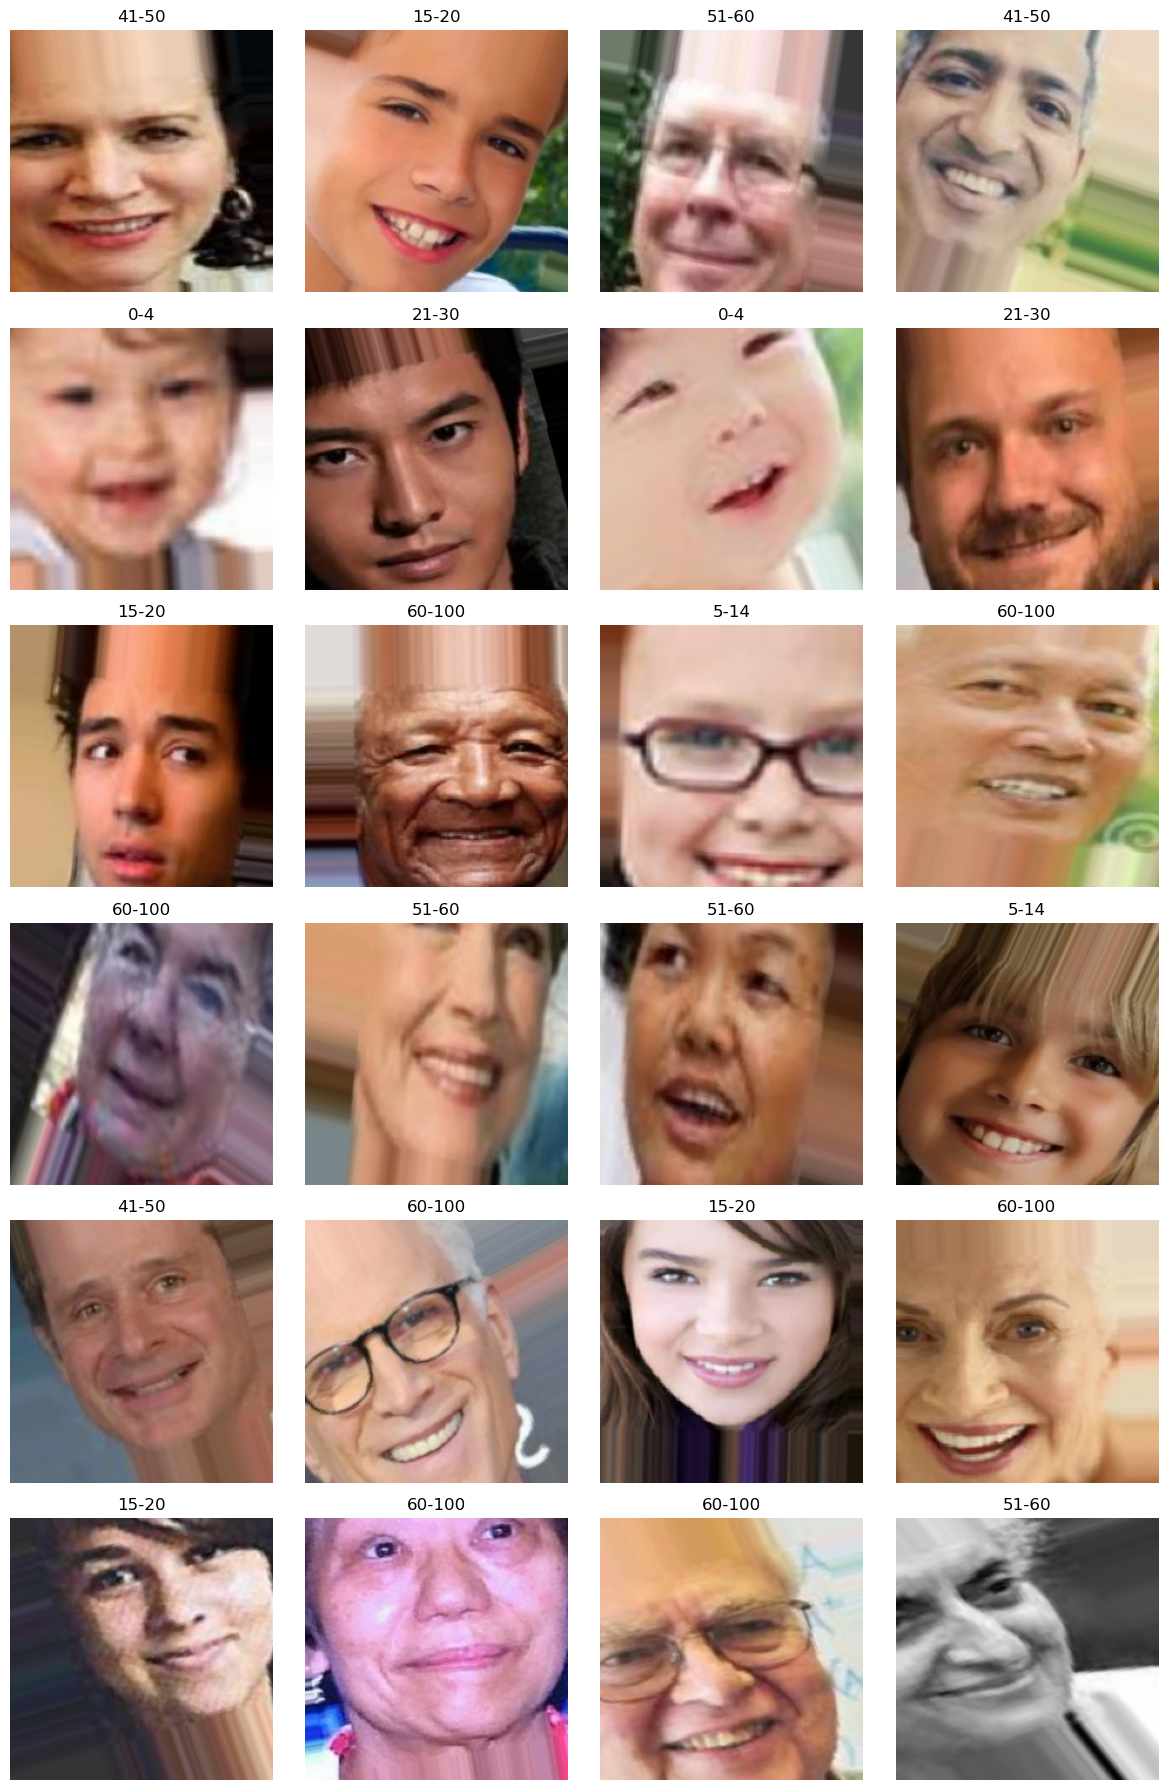

In [140]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

class_labels = list(train_gen.class_indices.keys())  # ['0-4', '5-14', '15-20',  '21-30', '31-40', '41-50', '51-60', '60-100'] or ['18-20',  '21-30', '31-40', '41-50', '51-60']
print(f"Class labels: {class_labels}")

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    class_index = y_batch[i].argmax()
    label = class_labels[class_index]
    
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [141]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_14 (Flatten)        (None, 51200)             0         
                                                                 
 dense_28 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 8)                 8200      
                                                                 
Total params: 74240808 (283.21 MB)
Trainable params: 59611336 (227.40 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=20,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/20
100/100 [==============================] - 30s 232ms/step - loss: 0.8578 - acc: 0.6664 - val_loss: 0.8160 - val_acc: 0.6853
Epoch 2/20
100/100 [==============================] - 22s 222ms/step - loss: 0.7962 - acc: 0.6800 - val_loss: 0.8097 - val_acc: 0.6830
Epoch 3/20
100/100 [==============================] - 22s 223ms/step - loss: 0.8064 - acc: 0.6846 - val_loss: 0.8215 - val_acc: 0.6865
Epoch 4/20
100/100 [==============================] - 22s 223ms/step - loss: 0.7854 - acc: 0.6879 - val_loss: 0.8074 - val_acc: 0.7051
Epoch 5/20
100/100 [==============================] - 22s 223ms/step - loss: 0.8219 - acc: 0.6768 - val_loss: 0.8012 - val_acc: 0.6807
Epoch 6/20
100/100 [==============================] - 22s 224ms/step - loss: 0.7990 - acc: 0.6837 - val_loss: 0.8024 - val_acc: 0.6935
Epoch 7/20
100/100 [==============================] - 22s 224ms/step - loss: 0.7975 - acc: 0.6779 - val_loss: 0.7998 - val_acc: 0.6876
Epoch 8/20
100/100 [==============================] - 2

# Plot the results of the training

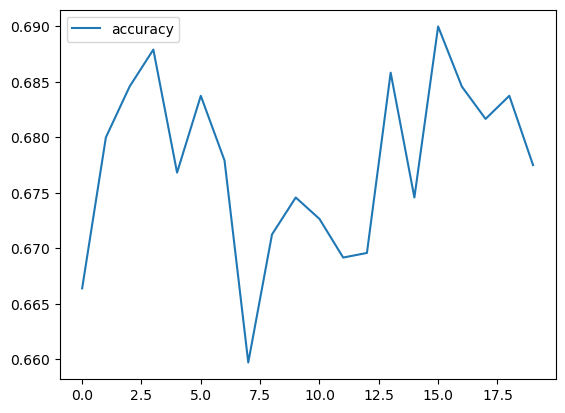

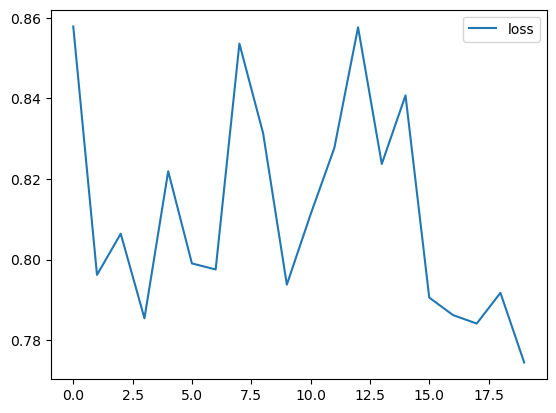

In [157]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


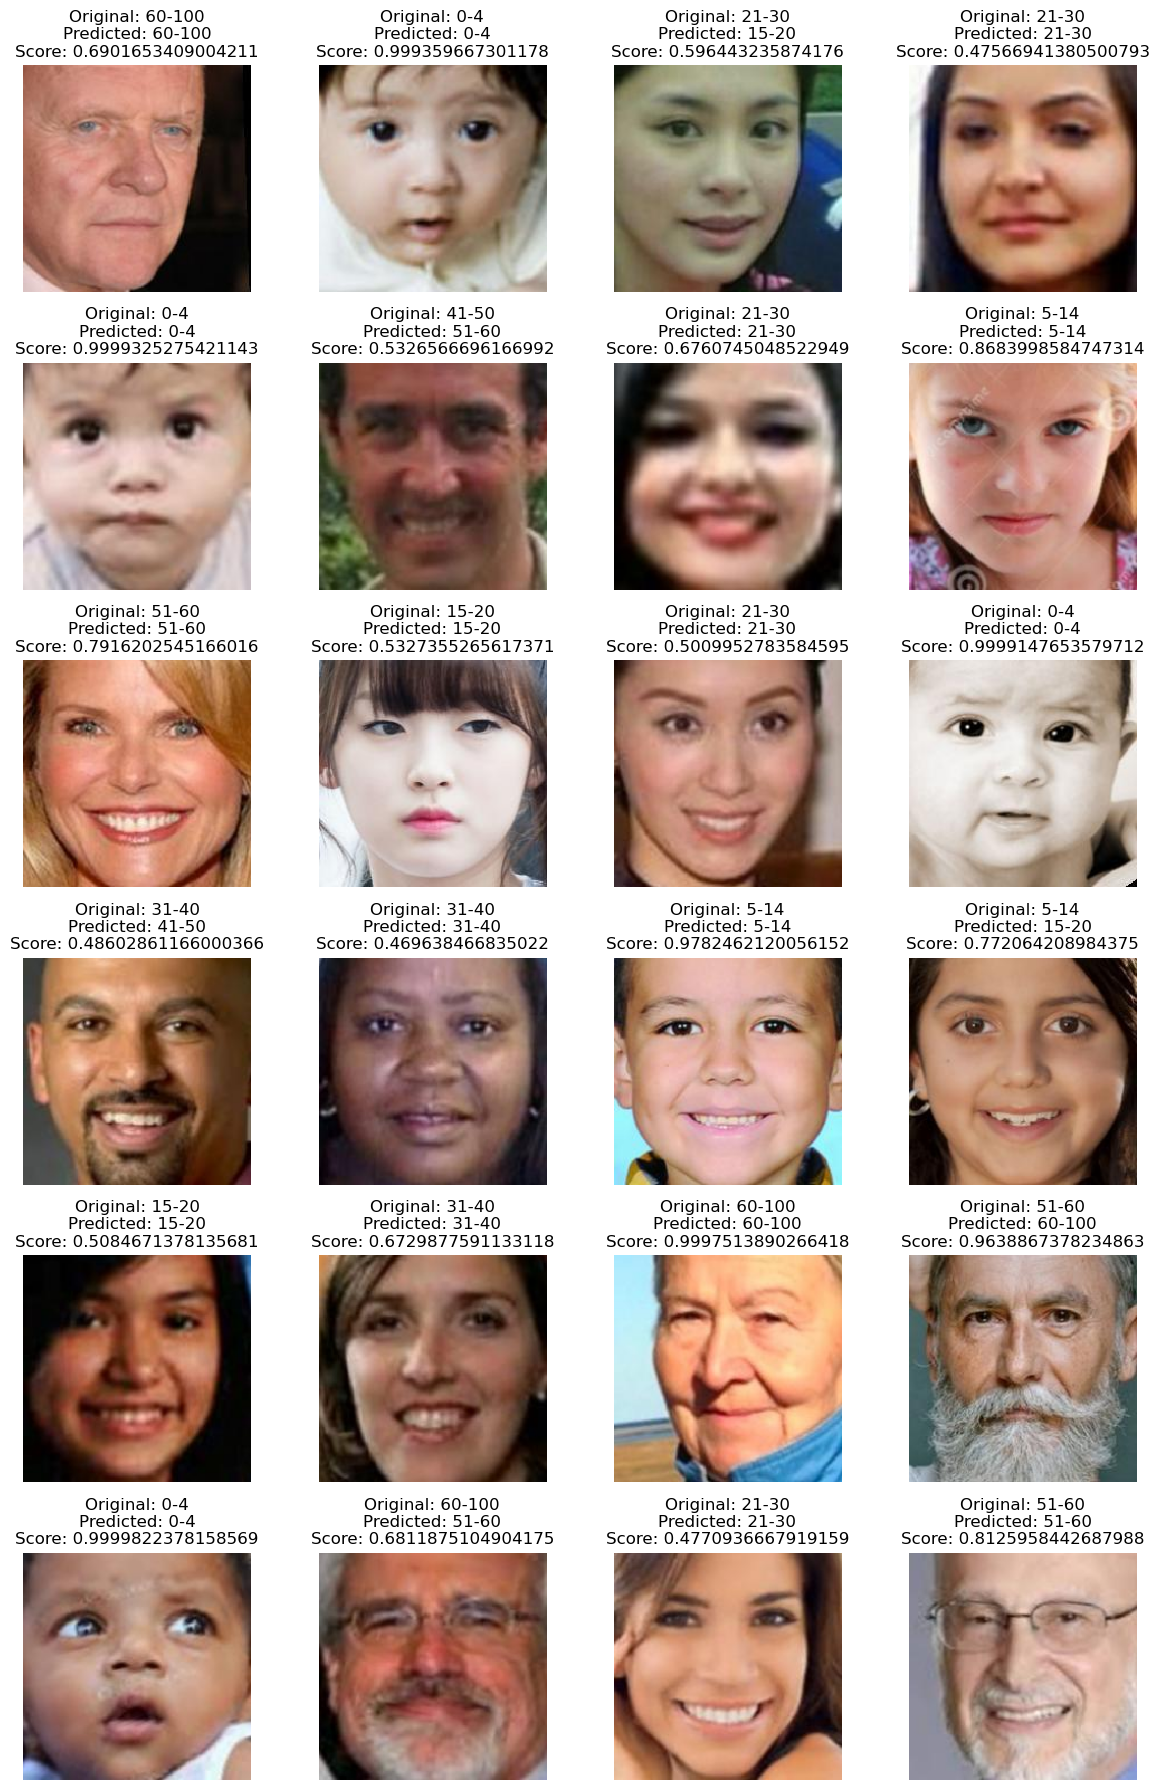

In [158]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])

    true_label = class_labels[true_labels[i]]
    predicted_label = class_labels[predicted_labels[i]]
    prediction_score = predictions[i][predicted_labels[i]]

    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {prediction_score}")
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 0s 38ms/step


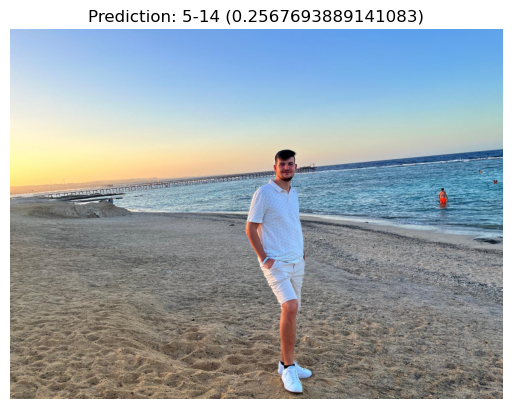

1/1 [==============================] - 0s 35ms/step


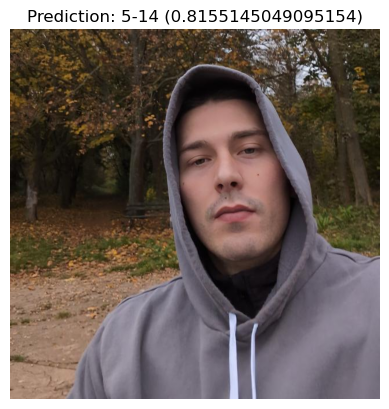

1/1 [==============================] - 0s 35ms/step


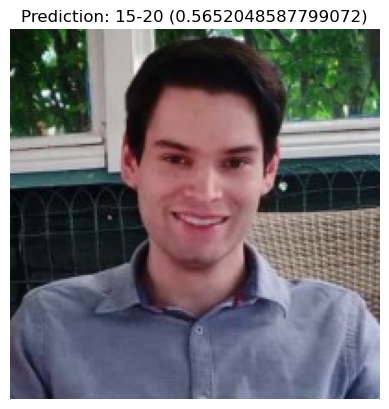

1/1 [==============================] - 0s 34ms/step


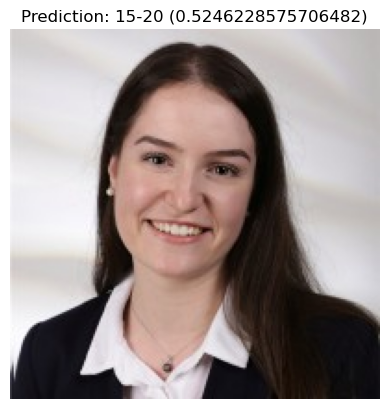

1/1 [==============================] - 0s 34ms/step


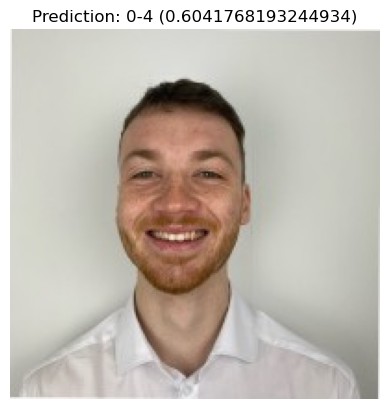

1/1 [==============================] - 0s 34ms/step


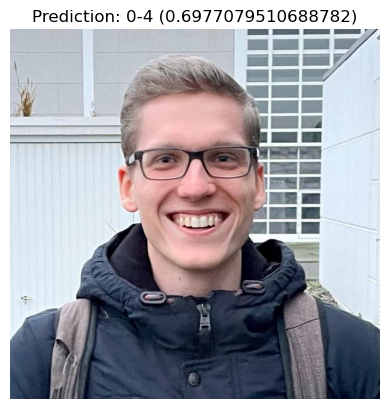

In [159]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)

    return img_array

images = glob.glob('../../TestImages/*.jpg')

for i, image in enumerate(images):
        img_array = edit_image(image)

        prediction = model.predict(img_array)

        predicted_label_index = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_label_index]
        confidence = prediction[0][predicted_label_index]

        plt.imshow(load_img(image))
        plt.title(f"Prediction: {predicted_label} ({confidence:})")
        plt.axis("off")
        plt.show()

# Evaluate the model ans save it to a file

In [155]:
model.evaluate(test_gen)
model.save("Age_classification.keras")

100/100 [==============================] - 4s 40ms/step - loss: 0.7591 - acc: 0.7006
